In [3]:
# Discriminator
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [6]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [0/5] Batch 0/938 Loss D: -0.0058, Loss G: -0.5012


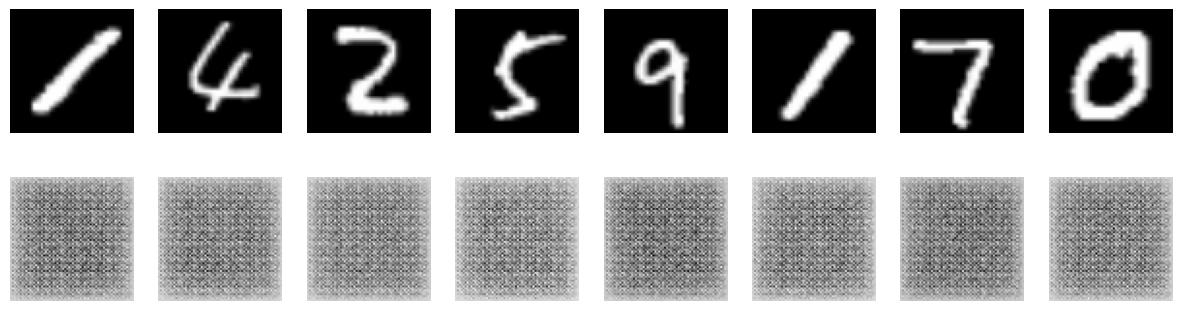

 21%|██▏       | 200/938 [01:54<08:02,  1.53it/s]

Epoch [0/5] Batch 200/938 Loss D: -1.0000, Loss G: -0.0000


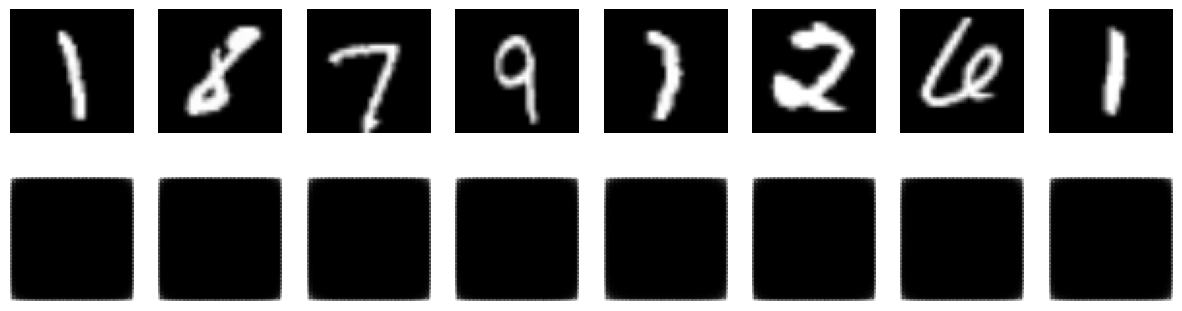

 43%|████▎     | 400/938 [04:03<05:45,  1.56it/s]

Epoch [0/5] Batch 400/938 Loss D: -1.0000, Loss G: -0.0000


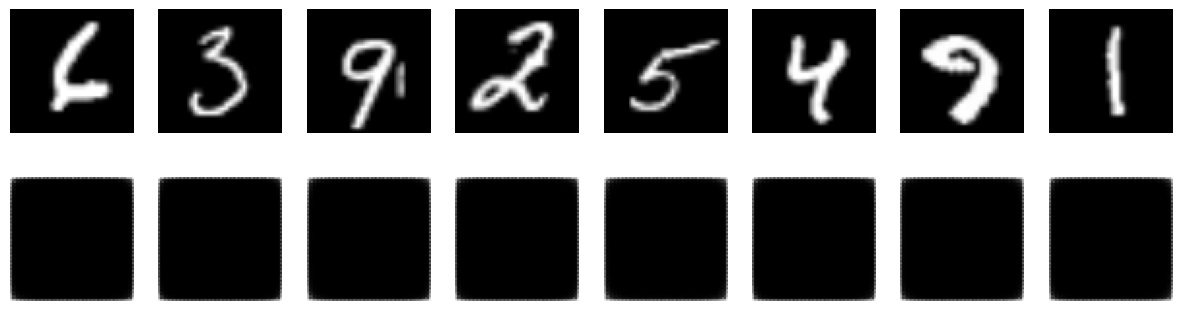

 49%|████▉     | 460/938 [04:41<05:01,  1.59it/s]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 128
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

# Data loading
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)],
                         [0.5 for _ in range(CHANNELS_IMG)]),
])

dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
#dataset = datasets.ImageFolder(root="/kaggle/input/cebradata/celeb_dataset", transform=transform)  
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize models
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# Optimizers
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

# Fixed noise for visualizing progress
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # Weight clipping
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Show results occasionally
        if batch_idx % 200 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake_images = gen(fixed_noise)
                fake_images = fake_images.detach().cpu()

            # Show real and fake images
            real_images = data[:32].cpu()

            fig, axs = plt.subplots(2, 8, figsize=(15, 4))
            for i in range(8):
                axs[0, i].imshow(real_images[i].permute(1, 2, 0).squeeze(), cmap="gray")
                axs[0, i].axis("off")
                axs[1, i].imshow(fake_images[i].permute(1, 2, 0).squeeze(), cmap="gray")
                axs[1, i].axis("off")

            axs[0, 0].set_ylabel("Real", size=14)
            axs[1, 0].set_ylabel("Fake", size=14)
            plt.show()
